In [8]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from matplotlib import style
style.use('./../figures/plotting.mplstyle')

In this notebook we'll compute and save the inferred mean and standard deviation of the BBH $\chi_\mathrm{eff}$ distribution under our single Gaussian and Double Gaussian models.

In [2]:
# First load inference data when fitting chi_eff as a single Gaussian
gaussian_data = az.from_netcdf("./../data/effective_spin_gaussian.cdf")
gaussian_stacked_samples = gaussian_data.posterior.stack(draws=("chain", "draw"))

# Extract means and standard deviations
gaussian_means = gaussian_stacked_samples['mu_chi'].values
gaussian_log_stds = gaussian_stacked_samples['logsig_chi'].values

In [6]:
# Reading out the means and std deviations directly ignores any correction due to the fact that
# our distributions are truncated on (-1,1). Because the chi_eff distribution is inferred to be
# narrowly concentrated at small values, this correction should be small. To be safe, let's check this
# by directly integrating to find the distributions' means and variances:

from scipy.special import erf
def gaussian(samples,mu,sigma,lowCutoff,highCutoff):
    
    """
    Function defining the probability density due to a truncated Gaussian
    """
    
    a = (lowCutoff-mu)/np.sqrt(2*sigma**2)
    b = (highCutoff-mu)/np.sqrt(2*sigma**2)
    norm = np.sqrt(sigma**2*np.pi/2)*(-erf(a) + erf(b))
    return np.exp(-(samples-mu)**2/(2.*sigma**2))/norm

# Instantiate arrays to hold manually computed quantities
chi_grid = np.linspace(-1,1,2000)
direct_means = np.zeros(gaussian_means.size)
direct_stds = np.zeros(gaussian_log_stds.size)

for i in range(gaussian_means.size):
    
    # Get PDF
    p_chi = gaussian(chi_grid,gaussian_means[i],10.**gaussian_log_stds[i],-1,1)
    
    # Manually integrate to obtain means and variances
    m = np.trapz(chi_grid*p_chi,chi_grid)
    var = np.trapz(chi_grid**2*p_chi,chi_grid) - m**2
    
    # Save
    direct_means[i] = m
    direct_stds[i] = np.sqrt(var)

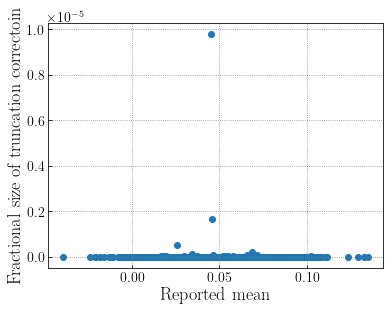

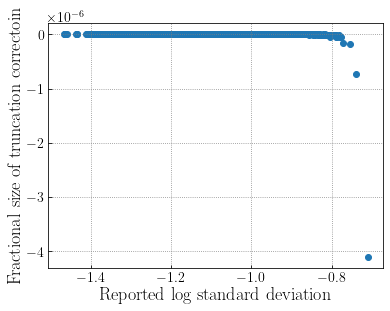

In [17]:
# Check residuals
# We see that the truncation correction changes the directly-inferred mean and log-stds by
# no more than one part in 1e5

fig,ax = plt.subplots()
ax.scatter(gaussian_means,(gaussian_means-direct_means)/gaussian_means)
ax.set_xlabel('Reported mean')
ax.set_ylabel('Fractional size of truncation correctoin')
plt.show()

fig,ax = plt.subplots()
ax.scatter(gaussian_log_stds,(gaussian_log_stds-np.log10(direct_stds))/gaussian_log_stds)
ax.set_xlabel('Reported log standard deviation')
ax.set_ylabel('Fractional size of truncation correctoin')
plt.show()

In [18]:
# Next load double Gaussian data
doubleGaussian_data = az.from_netcdf("./../data/effective_spin_doubleGaussians.cdf")
doubleGaussian_stacked_samples = doubleGaussian_data.posterior.stack(draws=("chain", "draw"))

In [24]:
# Define a grid of effective spins
chi_grid = np.linspace(-1,1,2000)

# Instantiate an array to hold means and std deviations
doubleGaussian_means = np.zeros(doubleGaussian_stacked_samples.zeta_high.size)
doubleGaussian_stds = np.zeros(doubleGaussian_stacked_samples.zeta_high.size)

for i in range(doubleGaussian_stacked_samples.zeta_high.size):
    
    zeta_high = doubleGaussian_stacked_samples.zeta_high.values[i]
    mu_chi_high = doubleGaussian_stacked_samples.mu_chi_high.values[i]
    logsig_chi_high = doubleGaussian_stacked_samples.logsig_chi_high.values[i]
    mu_chi_low = doubleGaussian_stacked_samples.mu_chi_low.values[i]
    logsig_chi_low = doubleGaussian_stacked_samples.logsig_chi_low.values[i]
    
    # Get PDF
    p_chi = zeta_high*gaussian(chi_grid,mu_chi_high,10.**logsig_chi_high,-1,1) \
        + (1.-zeta_high)*gaussian(chi_grid,mu_chi_low,10.**logsig_chi_low,-1,1)
    
    # Manually integrate to obtain means and variances
    m = np.trapz(chi_grid*p_chi,chi_grid)
    var = np.trapz(chi_grid**2*p_chi,chi_grid) - m**2
    
    # Save
    doubleGaussian_means[i] = m
    doubleGaussian_stds[i] = np.sqrt(var)    

In [60]:
with open('spin_summary_macros.txt','w') as macrofile:
    
    macrofile.write(\
        "\\newcommand{{gaussianChiEffMean}}{{ {0:.2f}^{{+ {1:.2f}}}_{{- {2:.2f}}} }}".format(\
        np.median(gaussian_means),
        np.median(gaussian_means)-np.quantile(gaussian_means,0.05),
        np.quantile(gaussian_means,0.95)-np.median(gaussian_means)))
    macrofile.write("\n")
    
    macrofile.write(\
        "\\newcommand{{gaussianChiEffStd}}{{ {0:.2f}^{{+ {1:.2f}}}_{{- {2:.2f}}} }}".format(\
        np.median(10.**gaussian_log_stds),
        np.median(10.**gaussian_log_stds)-np.quantile(10.**gaussian_log_stds,0.05),
        np.quantile(10.**gaussian_log_stds,0.95)-np.median(10.**gaussian_log_stds)))
    macrofile.write("\n")
    
    macrofile.write(\
        "\\newcommand{{doubleGaussianChiEffMean}}{{ {0:.2f}^{{+ {1:.2f}}}_{{- {2:.2f}}} }}".format(\
        np.median(doubleGaussian_means),
        np.median(doubleGaussian_means)-np.quantile(doubleGaussian_means,0.05),
        np.quantile(doubleGaussian_means,0.95)-np.median(doubleGaussian_means)))
    macrofile.write("\n")
    
    macrofile.write(\
        "\\newcommand{{doubleGaussianChiEffStd}}{{ {0:.2f}^{{+ {1:.2f}}}_{{- {2:.2f}}} }}".format(\
        np.median(doubleGaussian_stds),
        np.median(doubleGaussian_stds)-np.quantile(doubleGaussian_stds,0.05),
        np.quantile(doubleGaussian_stds,0.95)-np.median(doubleGaussian_stds)))
    macrofile.write("\n")